In [ ]:
!git clone https://github.com/AlicePH/Boosting-for-Fairness-Aware-Classification.git
%cd /content/Boosting-for-Fairness-Aware-Classification
!pip install -r requirements.txt

In [1]:
from utils.compute_metrics import *
from utils.compute_metrics import dfpr_score, dfnr_score

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

import pandas as pd

from SMOTEBoost.SMOTEBoost import SMOTEBoostClassifier
from AdaFair.AdaFair import AdaFairClassifier
from AdaptiveWeights.AdaptiveWeights import AdaptiveWeightsClassifier
from RAMOBoost.RAMOBoost import RAMOBoostClassifier
from CUSBoost.CUSBoost import CUSBoostClassifier

from utils.load_and_preprocess import load_kdd, load_compas, load_adult_census, load_bank
from utils.plot_bars import plot_bars

from tqdm import tqdm

from IPython.display import clear_output




In [2]:
base_clf_ab = DecisionTreeClassifier(max_depth=2)
base_clf_sb = DecisionTreeClassifier(max_depth=5)
base_clf_af = DecisionTreeClassifier(max_depth=2)
base_clf_aw = LogisticRegression(solver='liblinear')

random_state = 42

def criterion(y_true, y_pred, sensitive):
    acc = accuracy_score(y_true, y_pred)
    dfpr = dfpr_score(y_true, y_pred, sensitive)
    dfnr = dfnr_score(y_true, y_pred, sensitive)
    return 2 * acc - abs(dfpr) - abs(dfnr)

models = {'AdaBoost':AdaBoostClassifier(base_clf_ab, n_estimators=200),
          'SMOTEBoost':SMOTEBoostClassifier(base_clf_sb, 4, 20, 500),
          'AdaFair':AdaFairClassifier(base_clf_af, 4, 20, 500),
          'RAMOBoost':RAMOBoostClassifier(),
          'CUSBoost':CUSBoostClassifier(n_estimators=10, depth=5)}

def get_score_dic(scores):
    scores_dic = {"Accuracy": scores[0],
                  "Bal. Acc.": scores[1],
                  "Eq.Odds": scores[2],
                  "TPR Prot.": scores[3],
                  "TPR Non-prot.": scores[4],
                  "TNR Prot.": scores[5],
                  "TNR Non-prot.": scores[6]}
    return scores_dic


## Adult Census Dataset

In [3]:
adult_census_path = 'datasets/adult.csv'

X, y, sensitive = load_adult_census(adult_census_path)
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(X, y, sensitive, shuffle=True, random_state=random_state)

X_train_array, y_train_array, s_train_array = np.array(X_train.copy()), np.array(y_train.copy()), np.array(s_train.copy())
X_test_array, y_test_array, s_test_array = np.array(X_test.copy()), np.array(y_test.copy()), np.array(s_test.copy())

score_names = ['Accuracy', 'Bal. Acc.', 'Eq.Odds', 'TPR Prot.', 'TPR Non-prot.', 'TNR Prot.', 'TNR Non-prot.']
results_adult_census = pd.DataFrame(index=models.keys(), columns=score_names)

folds = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=42)

splits = folds.split(X, y)
n_splits = folds.get_n_splits()

columns = pd.MultiIndex.from_product([list(models.keys()), score_names], names=["Classifier", "Score"])
results_adult_census = pd.DataFrame(index=range(n_splits), columns=columns)
prog_bar = tqdm(splits, total=n_splits)

for i, (train_index, test_index) in enumerate(prog_bar):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    s_train, s_test = sensitive.iloc[train_index], sensitive.iloc[test_index]
    for model_name in models.keys():
        print(f'Training Adult Census Dataset on {model_name}')
        print('-------------------------------------------------')
        model = models[model_name]

        if model_name != 'CUSBoost':
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            scores = compute_metrics(y_test, y_pred, s_test)
        else:
            model.fit(X_train_array, y_train_array)
            y_pred = model.predict(X_test_array)[0]
            scores = compute_metrics(y_test_array, y_pred, s_test_array)

        scores_adult_census = get_score_dic(scores)
        for score, value in scores_adult_census.items():
            results_adult_census.loc[i, (model_name, score)] = value
    clear_output(wait=True)

save_results = results_adult_census.copy()
save_results.to_csv("results/adult_census_results.csv")


 30%|███       | 3/10 [03:40<08:18, 71.20s/it]

Training Adult Census Dataset on AdaBoost
-------------------------------------------------
Training Adult Census Dataset on SMOTEBoost
-------------------------------------------------
Training Adult Census Dataset on AdaFair
-------------------------------------------------
Training Adult Census Dataset on RAMOBoost
-------------------------------------------------


d:\miniconda3\envs\test_2\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RAMOBoostClassifier was fitted without feature names
  warnings.warn(


Training Adult Census Dataset on CUSBoost
-------------------------------------------------


 30%|███       | 3/10 [04:39<10:51, 93.13s/it]


KeyboardInterrupt: 

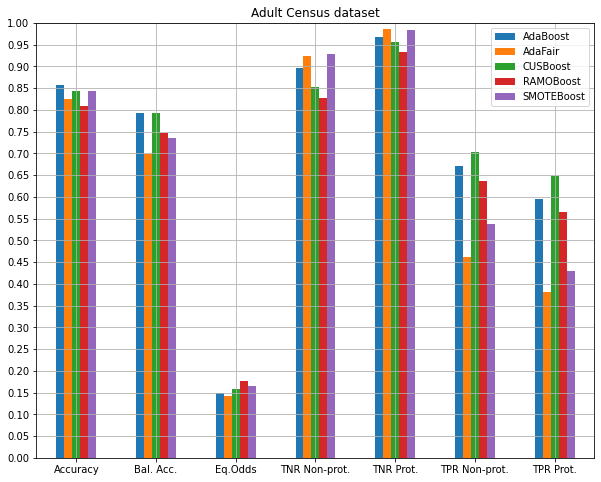

'Mean scores for Adult Census Dataset'

,Accuracy,Bal. Acc.,Eq.Odds,TNR Non-prot.,TNR Prot.,TPR Non-prot.,TPR Prot.
AdaBoost,0.858139,0.792140,0.149372,0.895814,0.968352,0.672108,0.595275
AdaFair,0.823931,0.699010,0.141929,0.924301,0.985633,0.462113,0.381515
CUSBoost,0.843257,0.793977,0.158332,0.852348,0.955363,0.703868,0.648551
RAMOBoost,0.808163,0.747009,0.175654,0.828234,0.934246,0.635552,0.565910
SMOTEBoost,0.843412,0.736129,0.166044,0.928227,0.984508,0.538698,0.428935


'Std of scores for Adult Census Dataset'

,Accuracy,Bal. Acc.,Eq.Odds,TNR Non-prot.,TNR Prot.,TPR Non-prot.,TPR Prot.
AdaBoost,0.003974,0.006354,0.027291,0.008255,0.006426,0.014959,0.033746
AdaFair,0.002912,0.007892,0.031542,0.012244,0.004662,0.023744,0.039454
CUSBoost,0.007036,0.017277,0.092870,0.037535,0.009014,0.062414,0.023912
RAMOBoost,0.005168,0.009379,0.055566,0.009133,0.007169,0.018318,0.050753
SMOTEBoost,0.009956,0.021202,0.053835,0.012968,0.007575,0.050689,0.047632


In [4]:
results_adult_census = pd.read_csv("results/adult_census_results.csv", index_col=[0], header=[0, 1])
adult_mean, adult_std = plot_bars(results_adult_census, title='Adult Census dataset')
display('Mean scores for Adult Census Dataset', adult_mean)
display('Std of scores for Adult Census Dataset', adult_std)

## Bank Dataset

In [5]:
bank_path = 'datasets/bank.csv'
X, y, sensitive = load_bank(bank_path)
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(X, y, sensitive, shuffle=True, random_state=random_state)

X_train_array, y_train_array, s_train_array = np.array(X_train.copy()), np.array(y_train.copy()), np.array(s_train.copy())
X_test_array, y_test_array, s_test_array = np.array(X_test.copy()), np.array(y_test.copy()), np.array(s_test.copy())

score_names = ['Accuracy', 'Bal. Acc.', 'Eq.Odds', 'TPR Prot.', 'TPR Non-prot.', 'TNR Prot.', 'TNR Non-prot.']
results_bank = pd.DataFrame(index=models.keys(), columns=score_names)

folds = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=42)

splits = folds.split(X, y)
n_splits = folds.get_n_splits()

columns = pd.MultiIndex.from_product([list(models.keys()), score_names], names=["Classifier", "Score"])
results_bank = pd.DataFrame(index=range(n_splits), columns=columns)
prog_bar = tqdm(splits, total=n_splits)

for i, (train_index, test_index) in enumerate(prog_bar):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    s_train, s_test = sensitive.iloc[train_index], sensitive.iloc[test_index]
    for model_name in models.keys():
        print(f'Training Bank Dataset on {model_name}')
        print('-------------------------------------------------')
        model = models[model_name]

        if model_name != 'CUSBoost':
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            scores = compute_metrics(y_test, y_pred, s_test)
        else:
            model.fit(X_train_array, y_train_array)
            y_pred = model.predict(X_test_array)[0]
            scores = compute_metrics(y_test_array, y_pred, s_test_array)

        scores_bank= get_score_dic(scores)
        for score, value in scores_bank.items():
            results_bank.loc[i, (model_name, score)] = value
    clear_output(wait=True)

save_results = results_bank.copy()
save_results.to_csv("results/bank_results.csv")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [06:58<00:00, 41.90s/it]


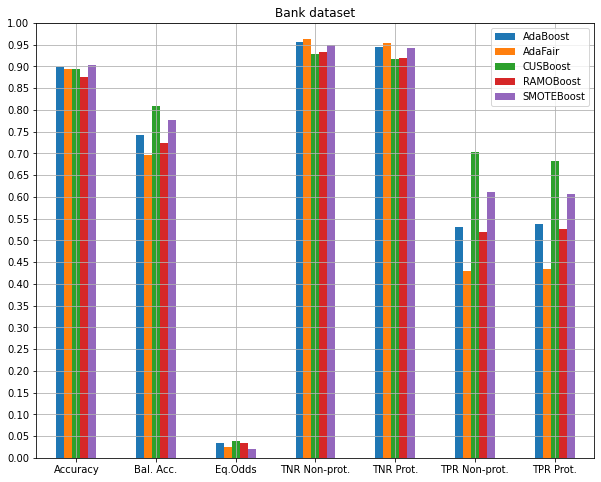

'Mean scores for Bank dataset'

,Accuracy,Bal. Acc.,Eq.Odds,TNR Non-prot.,TNR Prot.,TPR Non-prot.,TPR Prot.
AdaBoost,0.898813,0.742850,0.034665,0.956841,0.944561,0.530569,0.538088
AdaFair,0.893046,0.696076,0.024237,0.964021,0.954010,0.430612,0.434233
CUSBoost,0.895133,0.809308,0.038586,0.928806,0.918165,0.704112,0.682028
RAMOBoost,0.875768,0.724960,0.034314,0.933149,0.918245,0.520001,0.526436
SMOTEBoost,0.903641,0.777300,0.020219,0.950136,0.941396,0.610352,0.605503


'Std of scores for Bank dataset'

,Accuracy,Bal. Acc.,Eq.Odds,TNR Non-prot.,TNR Prot.,TPR Non-prot.,TPR Prot.
AdaBoost,0.002453,0.008502,0.031983,0.004444,0.004715,0.032537,0.029814
AdaFair,0.004849,0.010706,0.014987,0.003973,0.004172,0.026009,0.024161
CUSBoost,0.004739,0.023219,0.011980,0.009883,0.012135,0.057105,0.056773
RAMOBoost,0.005133,0.014326,0.023450,0.006308,0.009773,0.042699,0.033199
SMOTEBoost,0.004777,0.022559,0.021119,0.008295,0.010435,0.054455,0.053282


In [6]:
results_bank = pd.read_csv("results/bank_results.csv", index_col=[0], header=[0, 1])
bank_mean, bank_std = plot_bars(results_bank, title='Bank dataset')
display('Mean scores for Bank dataset', bank_mean)
display('Std of scores for Bank dataset', bank_std)

## KDD Census dataset

In [7]:
kdd_path = 'datasets/kdd_census_income.csv'
X, y, sensitive = load_kdd(kdd_path)
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(X, y, sensitive, shuffle=True, random_state=random_state)

X_train_array, y_train_array, s_train_array = np.array(X_train.copy()), np.array(y_train.copy()), np.array(s_train.copy())
X_test_array, y_test_array, s_test_array = np.array(X_test.copy()), np.array(y_test.copy()), np.array(s_test.copy())

score_names = ['Accuracy', 'Bal. Acc.', 'Eq.Odds', 'TPR Prot.', 'TPR Non-prot.', 'TNR Prot.', 'TNR Non-prot.']
results_kdd = pd.DataFrame(index=models.keys(), columns=score_names)

folds = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=42)

splits = folds.split(X, y)
n_splits = folds.get_n_splits()

columns = pd.MultiIndex.from_product([list(models.keys()), score_names], names=["Classifier", "Score"])
results_kdd = pd.DataFrame(index=range(n_splits), columns=columns)
prog_bar = tqdm(splits, total=n_splits)

for i, (train_index, test_index) in enumerate(prog_bar):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    s_train, s_test = sensitive.iloc[train_index], sensitive.iloc[test_index]
    for model_name in models.keys():
        print(f'Training KDD Dataset on {model_name}')
        print('-------------------------------------------------')
        model = models[model_name]

        if model_name != 'CUSBoost':
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            scores = compute_metrics(y_test, y_pred, s_test)
        else:
            model.fit(X_train_array, y_train_array)
            y_pred = model.predict(X_test_array)[0]
            scores = compute_metrics(y_test_array, y_pred, s_test_array)

        scores_kdd= get_score_dic(scores)
        for score, value in scores_kdd.items():
            results_kdd.loc[i, (model_name, score)] = value
    clear_output(wait=True)

save_results = results_kdd.copy()
save_results.to_csv("results/kdd_results.csv")

100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [1:44:33<00:00, 627.40s/it]


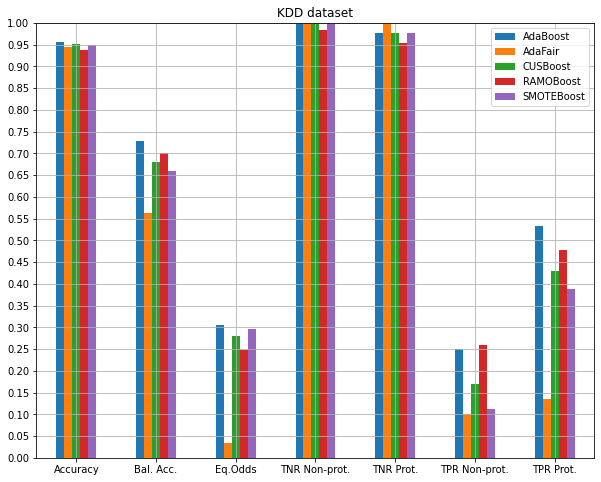

'Mean scores for KDD dataset'

,Accuracy,Bal. Acc.,Eq.Odds,TNR Non-prot.,TNR Prot.,TPR Non-prot.,TPR Prot.
AdaBoost,0.955161,0.729493,0.304643,0.996791,0.975744,0.249261,0.532858
AdaFair,0.944458,0.562790,0.033255,0.998579,0.998497,0.101027,0.134164
CUSBoost,0.951074,0.680469,0.279286,0.996618,0.976710,0.169108,0.428486
RAMOBoost,0.937426,0.701274,0.248758,0.984780,0.954502,0.260165,0.478645
SMOTEBoost,0.948329,0.659339,0.296384,0.998917,0.977906,0.113292,0.388666


'Std of scores for KDD dataset'

,Accuracy,Bal. Acc.,Eq.Odds,TNR Non-prot.,TNR Prot.,TPR Non-prot.,TPR Prot.
AdaBoost,0.000822,0.005479,0.024866,0.001032,0.002354,0.021986,0.013412
AdaFair,0.000375,0.003989,0.009245,0.000366,0.000211,0.008138,0.009149
CUSBoost,0.000964,0.012362,0.053205,0.001399,0.005301,0.031412,0.034037
RAMOBoost,0.021482,0.037678,0.039086,0.019286,0.041853,0.129546,0.099375
SMOTEBoost,0.001556,0.023035,0.071280,0.000747,0.010427,0.011051,0.064318


In [8]:
results_kdd = pd.read_csv("results/kdd_results.csv", index_col=[0], header=[0, 1])
kdd_mean, kdd_std = plot_bars(results_kdd, title='KDD dataset')
display('Mean scores for KDD dataset', kdd_mean)
display('Std of scores for KDD dataset', kdd_std)

## COMPAS dataset

In [9]:
compas_path = 'datasets/compas-scores-two-years_works.csv'
X, y, sensitive = load_compas(compas_path)
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(X, y, sensitive, shuffle=True, random_state=random_state)

X_train_array, y_train_array, s_train_array = np.array(X_train.copy()), np.array(y_train.copy()), np.array(s_train.copy())
X_test_array, y_test_array, s_test_array = np.array(X_test.copy()), np.array(y_test.copy()), np.array(s_test.copy())

score_names = ['Accuracy', 'Bal. Acc.', 'Eq.Odds', 'TPR Prot.', 'TPR Non-prot.', 'TNR Prot.', 'TNR Non-prot.']
results_compas = pd.DataFrame(index=models.keys(), columns=score_names)

folds = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=42)

splits = folds.split(X, y)
n_splits = folds.get_n_splits()

columns = pd.MultiIndex.from_product([list(models.keys()), score_names], names=["Classifier", "Score"])
results_compas = pd.DataFrame(index=range(n_splits), columns=columns)
prog_bar = tqdm(splits, total=n_splits)

for i, (train_index, test_index) in enumerate(prog_bar):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    s_train, s_test = sensitive.iloc[train_index], sensitive.iloc[test_index]
    for model_name in models.keys():
        print(f'Training COMPAS Dataset on {model_name}')
        print('-------------------------------------------------')
        model = models[model_name]

        if model_name != 'CUSBoost':
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            scores = compute_metrics(y_test, y_pred, s_test)
        else:
            model.fit(X_train_array, y_train_array)
            y_pred = model.predict(X_test_array)[0]
            scores = compute_metrics(y_test_array, y_pred, s_test_array)

        scores_compas= get_score_dic(scores)
        for score, value in scores_compas.items():
            results_compas.loc[i, (model_name, score)] = value
    clear_output(wait=True)

save_results = results_compas.copy()
save_results.to_csv("results/compas_results.csv")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:51<00:00, 11.18s/it]


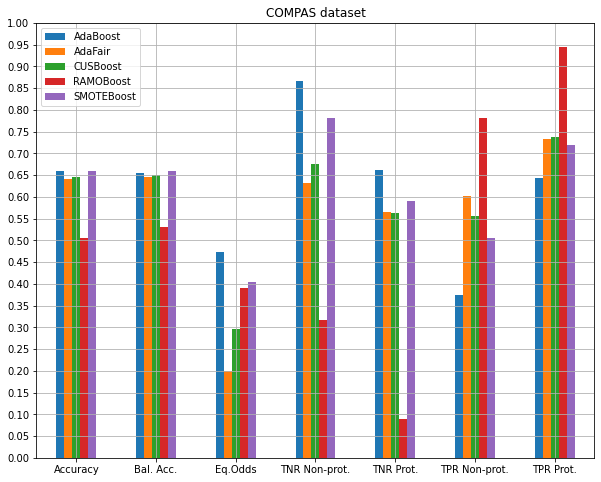

'Mean scores for COMPAS dataset'

,Accuracy,Bal. Acc.,Eq.Odds,TNR Non-prot.,TNR Prot.,TPR Non-prot.,TPR Prot.
AdaBoost,0.659285,0.655657,0.473654,0.866225,0.661275,0.375042,0.643746
AdaFair,0.642016,0.646507,0.199264,0.632014,0.564210,0.601753,0.733213
CUSBoost,0.646099,0.649524,0.296754,0.676000,0.562264,0.554902,0.737920
RAMOBoost,0.504813,0.531075,0.391230,0.317568,0.089819,0.781237,0.944718
SMOTEBoost,0.658829,0.660556,0.405107,0.781124,0.590154,0.505259,0.719396


'Std of scores for COMPAS dataset'

,Accuracy,Bal. Acc.,Eq.Odds,TNR Non-prot.,TNR Prot.,TPR Non-prot.,TPR Prot.
AdaBoost,0.010302,0.010793,0.222027,0.058628,0.050842,0.097383,0.052013
AdaFair,0.011731,0.017878,0.082693,0.127953,0.105001,0.143385,0.139381
CUSBoost,0.017209,0.016103,0.260876,0.114799,0.058385,0.105874,0.030313
RAMOBoost,0.019066,0.017426,0.218807,0.113954,0.053980,0.079110,0.014915
SMOTEBoost,0.022588,0.021049,0.148442,0.104923,0.068870,0.115152,0.059591


In [10]:
results_compas = pd.read_csv("results/compas_results.csv", index_col=[0], header=[0, 1])
compas_mean, compas_std = plot_bars(results_compas, title='COMPAS dataset')
display('Mean scores for COMPAS dataset', compas_mean)
display('Std of scores for COMPAS dataset', compas_std)